# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator# < Перенесите сюда исследовательский анализ данных >
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 



Found 7591 validated image filenames.


In [3]:
print(labels['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


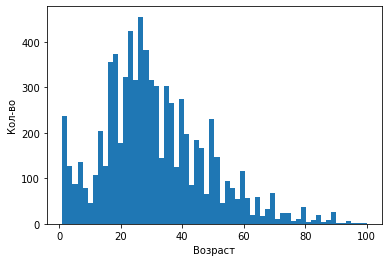

In [10]:
plt.hist(labels['real_age'], bins=60)
plt.xlabel('Возраст')
plt.ylabel('Кол-во')
plt.show()

- Распределение возрастов в выборке соответсвует форме пуассоновского распределения. 
- Разброс значений от 1 до 100, при этом среднее и медиана находятся относительно близко - 29 и 31. При этом, вариативность достаточно большаядля данной медианы - 17. 
- По графику так же наблюдается пик в районе 28-32. При этом, меньших значений больше. 
- Людей более старшего возраста(>60) мало.

000000.jpg
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg


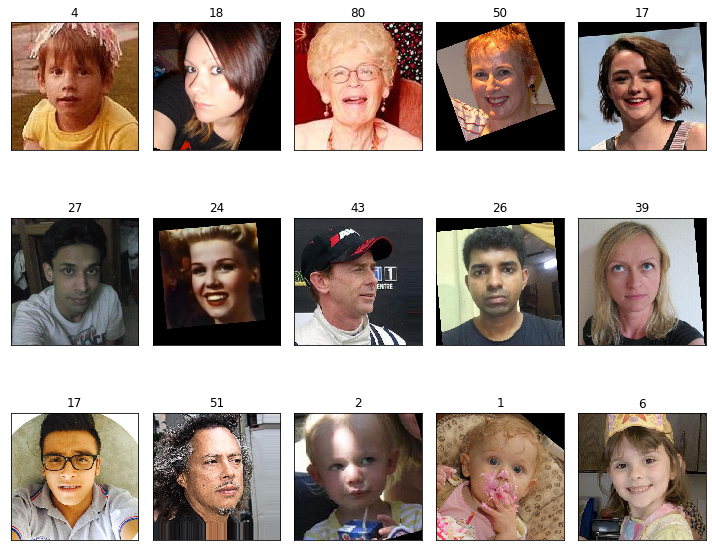

In [18]:
image_names = labels['file_name']
fig = plt.figure(figsize=(10,10))
features = []

for name in image_names[0:15]:
    print(name)
    features.append(np.array(Image.open('/datasets/faces/final_files/' + name)))
    
for i in range(len(features)): 
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(labels['real_age'][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
 


# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
 
 
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```python


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
 
 
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```python


import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
 
 
 
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
2020-12-10 06:49:28.906876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-12-10 06:49:28.908639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-12-10 06:49:30.486687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-12-10 06:49:31.127623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-12-10 06:49:31.127689: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-10 06:49:31.127734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-10 06:49:31.129836: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-12-10 06:49:31.130234: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-12-10 06:49:31.132707: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-12-10 06:49:31.133985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-12-10 06:49:31.134059: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-12-10 06:49:31.137756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-12-10 06:49:31.138253: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-12-10 06:49:31.145970: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-12-10 06:49:31.146706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59c2ca0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-12-10 06:49:31.146734: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-12-10 06:49:31.275967: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5a48cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-12-10 06:49:31.276010: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-12-10 06:49:31.278034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-12-10 06:49:31.278112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-10 06:49:31.278124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-10 06:49:31.278148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-12-10 06:49:31.278162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-12-10 06:49:31.278174: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-12-10 06:49:31.278186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-12-10 06:49:31.278195: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-12-10 06:49:31.281810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-12-10 06:49:31.281855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-12-10 06:49:31.611924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-12-10 06:49:31.611995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-12-10 06:49:31.612004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-12-10 06:49:31.615749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2020-12-10 06:49:44.082688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-12-10 06:49:44.412886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 111s - loss: 213.4002 - mae: 10.9425 - val_loss: 409.0615 - val_mae: 15.2230
Epoch 2/20
356/356 - 42s - loss: 135.3626 - mae: 8.8929 - val_loss: 217.3973 - val_mae: 11.4319
Epoch 3/20
356/356 - 41s - loss: 110.6296 - mae: 8.0622 - val_loss: 107.9231 - val_mae: 7.8879
Epoch 4/20
356/356 - 41s - loss: 94.1705 - mae: 7.3757 - val_loss: 110.5487 - val_mae: 8.2154
Epoch 5/20
356/356 - 41s - loss: 76.7698 - mae: 6.6635 - val_loss: 192.6252 - val_mae: 10.6101
Epoch 6/20
356/356 - 41s - loss: 65.7923 - mae: 6.2543 - val_loss: 107.9436 - val_mae: 8.1381
Epoch 7/20
356/356 - 41s - loss: 56.0264 - mae: 5.7124 - val_loss: 122.7913 - val_mae: 8.3110
Epoch 8/20
356/356 - 42s - loss: 49.2015 - mae: 5.4099 - val_loss: 95.2562 - val_mae: 7.4687
Epoch 9/20
356/356 - 42s - loss: 42.6680 - mae: 5.0294 - val_loss: 107.5351 - val_mae: 7.8993
Epoch 10/20
356/356 - 41s - loss: 37.7218 - mae: 4.7358 - val_loss: 119.6765 - val_mae: 8.0638
Epoch 11/20
356/356 - 42s - loss: 32.9712 - mae: 4.4235 - val_loss: 106.4950 - val_mae: 8.2271
Epoch 12/20
356/356 - 43s - loss: 27.7030 - mae: 4.0407 - val_loss: 132.8492 - val_mae: 8.7604
Epoch 13/20
356/356 - 41s - loss: 24.4689 - mae: 3.8051 - val_loss: 98.0450 - val_mae: 7.3602
Epoch 14/20
356/356 - 42s - loss: 23.2346 - mae: 3.7042 - val_loss: 85.0279 - val_mae: 6.9230
Epoch 15/20
356/356 - 42s - loss: 20.8841 - mae: 3.5430 - val_loss: 135.8424 - val_mae: 9.1777
Epoch 16/20
356/356 - 41s - loss: 22.5981 - mae: 3.6731 - val_loss: 117.1099 - val_mae: 7.9613
Epoch 17/20
356/356 - 42s - loss: 20.8302 - mae: 3.5058 - val_loss: 81.3134 - val_mae: 6.7831
Epoch 18/20
356/356 - 42s - loss: 21.5499 - mae: 3.5558 - val_loss: 91.9203 - val_mae: 7.3481
Epoch 19/20
356/356 - 41s - loss: 19.6348 - mae: 3.4215 - val_loss: 94.9301 - val_mae: 7.1876
Epoch 20/20
356/356 - 41s - loss: 17.8240 - mae: 3.2274 - val_loss: 78.7737 - val_mae: 6.7116
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 78.7737 - mae: 6.7116
Test MAE: 6.7116 # < скопируйте результат вывода на экран сюда >

```

# 3. Анализ обученной модели

- Модель предсказывает возраст по фото с погрешностью 6.7116 по метрике MAE. Максимальный возраст - 100. Таким образом, погрешность тем значимее, чем меньше target взраст.
- MAE ниже почти в два раза на тренировочных данных, что говорит о некотором переобучении.
- Функция потерь, как и mae падает с каждой эпохой, что соответсвует ожиданиям о работе градиентного спуска.


- В датасете все изображения развернуты таким образом, чтобы landmark средней линии лица был параллельным краям изображения. Для улучшения предсказания можно было бы добавить повороты изображений, однако это улучшит mae только если в test встречаются перевернутые изображения(а если нет, погрешность связана с чем-то другим, и такой способ не сработает).
- Корректировка lr в оптимизаторе на более меньший может улучшить результат предсказания. Но это так же увеличит время обучения.
- <b>Малая часть изображений предлагает фото лиц в профиль или полу профиль. Возможно, это вносит путаницу в решения алгоритма.Необходимо проверить и исключить влияние этого фактора.</b>

### Вывод
- Для улучшения качества предсказания важно применить методы Explainable AI. Это позволит понять, какие признаки изображений были наиболее влиятельными в предсказании и скорректировать их влияние внутри выборки.
- Субъективное качество решаемой задачи необходио оценивать исходя из предназначения данного агоритма. Алгоритм с такой точностью вполне решал бы задачу для развлекающего приложения. Если распознавание возраста необходмо для организационных задач, здесь бы уже возникли проблемы, связанные с ошибками, особенно на границе ребенок-взрослый (тк для меньших значений полученная погрешность более значительна)